# Classification Task: Predicting Tax Avoidance Categories

**ML2 Course - Extra Points Assignment (5 points)**

---

## Task Overview

In the original project, we predicted **continuous ETR values** (regression). Your task is to convert this into a **classification problem** by categorizing companies into **tax avoidance risk levels**.

**Target Variable Transformation:**
- **Low Tax Avoidance** (Class 0): ETR > 0.25 (companies paying relatively high taxes)
- **Medium Tax Avoidance** (Class 1): 0.15 < ETR ≤ 0.25
- **High Tax Avoidance** (Class 2): ETR ≤ 0.15 (companies with aggressive tax optimization)

---

## Instructions

### Part 1: Data Preparation (1 point)
1. Load the prepared datasets (`train_fe.csv` and `test_fe.csv`)
2. Create the target classification variable based on ETR thresholds above
3. Check class balance and visualize the distribution
4. Select features (use existing feature engineering from the project)

### Part 2: Model Training (1.5 points)
Train and evaluate **THREE** classification models:
1. **Logistic Regression** (multiclass)
2. **K-Nearest Neighbors Classifier**
3. **Support Vector Classifier (SVC)**

For each model:
- Perform hyperparameter tuning (use GridSearchCV or similar)
- Use proper cross-validation strategy for time-series data
- Evaluate on training set using CV

### Part 3: Final Evaluation (0.5 points)
1. Select the best model based on validation performance
2. Evaluate on the test set using:
   - **Accuracy**
   - **Precision, Recall, F1-Score** (for each class)
   - **Confusion Matrix**
3. Compare results across all three models
4. Provide brief interpretation (2-3 sentences)

---

## Evaluation Metrics

Primary metric: **Macro F1-Score** (equally weights all classes)

Secondary metrics: Accuracy, Confusion Matrix

---

## Submission Requirements

- Complete this notebook with code and outputs
- Save best model(s) as pickle files in `models/` directory
- Commit and push to your GitHub repository
- Send repository link to: **mj.wozniak9@uw.edu.pl**

**Deadline:** [To be announced by instructor]

---

Good luck! 🚀


In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

root = Path().resolve().parent
root

PosixPath('/Users/gregruyoga/gmoneycodes/MLClass')

# Data Preparation

In [2]:
train = pd.read_csv(root / 'data' / 'output'/ 'train_fe.csv', index_col=0)
test = pd.read_csv(root / 'data' / 'output'/ 'test_fe.csv', index_col=0)

def create_targets(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target'] = df['etr'].apply(
        lambda x: 0 if x > 0.25 else (1 if x > 0.15 else 2)
    )
    return df

train = create_targets(train)
test = create_targets(test)

/opt/homebrew/Caskroom/miniconda/base/envs/mlclass/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


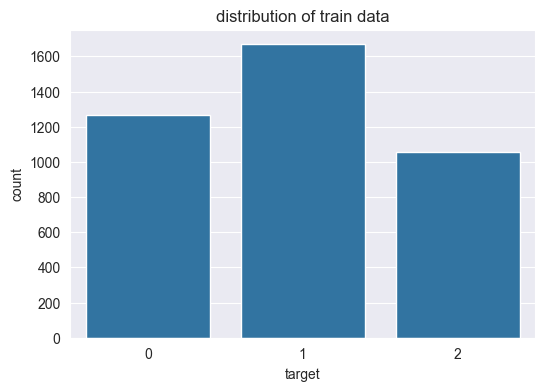

target
1    1668
0    1267
2    1058
Name: count, dtype: int64

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train)
plt.title('distribution of train data')
plt.show()
train['target'].value_counts()

/opt/homebrew/Caskroom/miniconda/base/envs/mlclass/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


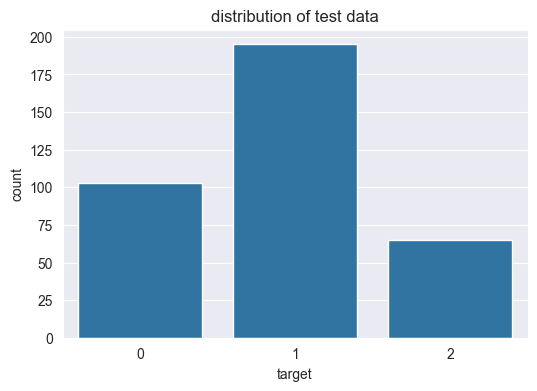

target
1    195
0    103
2     65
Name: count, dtype: int64

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=test)
plt.title('distribution of test data')
plt.show()
test['target'].value_counts()

## Standardization for numeric features

In [5]:
num_cols = train.select_dtypes(include=[np.number]).columns

exclude = {'target'}
scale_cols = [c for c in num_cols if train[c].nunique(dropna=True) > 2 and c not in exclude]

scaler = MinMaxScaler()
scaler.fit(train[scale_cols])

train[scale_cols] = scaler.transform(train[scale_cols])
test[scale_cols]  = scaler.transform(test[scale_cols])

# Feature Selection

In [12]:
exclude_cols = {'target', 'etr'}
num_feature_cols = (
    train.select_dtypes(include=[np.number])
         .columns.difference(exclude_cols)
         .tolist()
)

def non_constant_cols(df, cols):
    nunique = df[cols].nunique(dropna=False)
    keep = nunique[nunique > 1].index.tolist()
    return keep

num_feature_cols = non_constant_cols(train, num_feature_cols)

X_train = train[num_feature_cols].copy()
y_train = train['target'].copy()

X_test = test[num_feature_cols].copy()
y_test = test['target'] if 'target' in test.columns else None

imp = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=num_feature_cols, index=train.index)
X_test  = pd.DataFrame(imp.transform(X_test),  columns=num_feature_cols, index=test.index)

estimator = LogisticRegression(
    max_iter=1000,
    solver='saga',
    penalty='l2',
    C=1.0,
    class_weight='balanced',  # helpful if classes are imbalanced
)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

sfs = SFS(
    estimator=estimator,
    k_features=30,
    forward=True,
    floating=True,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X_train, y_train)

selected_features = list(sfs.k_feature_names_)   # now actual column names
best_cv_score = sfs.k_score_
print(f"Selected {len(selected_features)} features. CV macro-F1: {best_cv_score:.4f}")
print("Features:", selected_features)

X_train_sfs = X_train[selected_features].copy()
X_test_sfs  = X_test[selected_features].copy()

estimator.fit(X_train_sfs, y_train)
if y_test is not None:
    y_pred = estimator.predict(X_test_sfs)
    print("Test macro-F1:", f1_score(y_test, y_pred, average='macro'))

Selected 30 features. CV macro-F1: 0.6592
Features: ['adv', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'adv_expenditure', 'adv_expenditure_positive', 'capex2', 'capex2_scaled', 'capex_cat_(5451.0, inf]', 'cce', 'diff', 'diff_dta', 'diff_ma', 'dlc', 'dlc_cat_(176.129, 200.9]', 'dltt', 'etr_y_past', 'ni', 'ni_profit_20000', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'roa_ma', 'roa_past', 'sektor_consumer staples', 'sektor_energy', 'sektor_technology', 'ta', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(308.55, 327.531]']
Test macro-F1: 0.5643789854233076


# Model training

In [15]:
X = train[selected_features].copy()
y = train['target'].copy()

tscv = TimeSeriesSplit(n_splits=5)

def run_model(name, pipe, param_grid, cv, scoring='f1_macro'):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
        return_train_score=False,
    )
    gs.fit(X, y)

    best_mean = gs.best_score_
    results = pd.DataFrame(gs.cv_results_)
    std_at_best = results.loc[results['rank_test_score'] == 1, 'std_test_score'].values[0]

    print(f"\n[{name}]")
    print(f"Best CV {scoring}: {best_mean:.4f} ± {std_at_best:.4f}")
    print("Best params:", gs.best_params_)

    return gs, results

logreg_pipe = Pipeline([
    ('clf', LogisticRegression(max_iter=5000, penalty='l2', class_weight='balanced', solver='lbfgs'))
])
logreg_grid = {
    'clf__C': [0.05, 0.1, 0.5, 1.0, 2.0, 5.0],
}

logreg_gs, logreg_results = run_model("Logistic Regression", logreg_pipe, logreg_grid, tscv)



[Logistic Regression]
Best CV f1_macro: 0.6005 ± 0.0181
Best params: {'clf__C': 0.5}


In [16]:
knn_pipe = Pipeline([
    ('clf', KNeighborsClassifier())
])
knn_grid = {
    'clf__n_neighbors': [3, 5, 9, 15, 25],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],
}

knn_gs, knn_results = run_model("K-Nearest Neighbors", knn_pipe, knn_grid, tscv)


[K-Nearest Neighbors]
Best CV f1_macro: 0.6203 ± 0.0248
Best params: {'clf__n_neighbors': 25, 'clf__p': 2, 'clf__weights': 'uniform'}


In [17]:
# --- 5) Support Vector Classifier ---
svc_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('clf', SVC(class_weight='balanced'))
])
svc_grid = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.1, 0.5, 1.0, 2.0, 5.0],
    },
    {
        'clf__kernel': ['rbf'],
        'clf__C': [0.1, 0.5, 1.0, 2.0, 5.0],
        'clf__gamma': ['scale', 'auto'],
    }
]

svc_gs, svc_results = run_model("SVC", svc_pipe, svc_grid, tscv)


[SVC]
Best CV f1_macro: 0.6279 ± 0.0186
Best params: {'clf__C': 5.0, 'clf__kernel': 'linear'}


In [18]:
summary = pd.DataFrame({
    'model': ['LogReg', 'KNN', 'SVC'],
    'cv_f1_macro_mean': [logreg_gs.best_score_, knn_gs.best_score_, svc_gs.best_score_],
})
print("\nCV summary (training-set, time-series CV):")
print(summary.sort_values('cv_f1_macro_mean', ascending=False).reset_index(drop=True))



CV summary (training-set, time-series CV):
    model  cv_f1_macro_mean
0     SVC          0.627871
1     KNN          0.620303
2  LogReg          0.600550


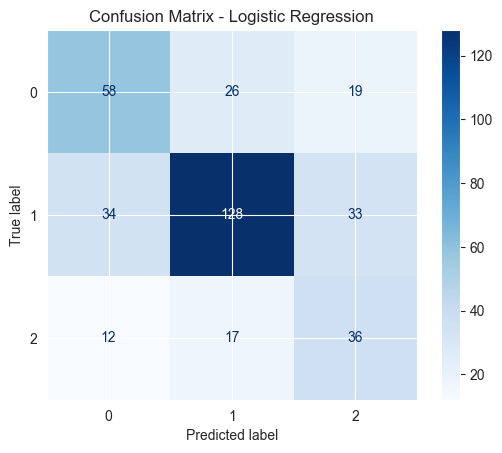

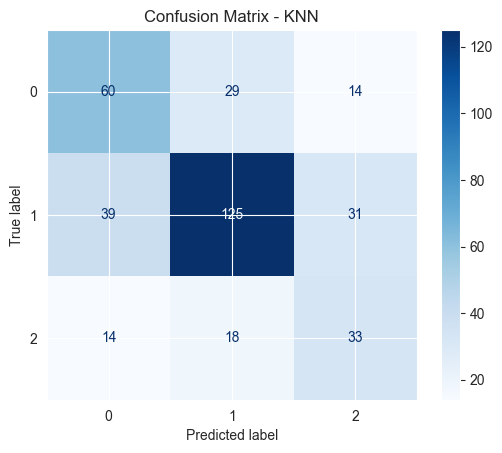

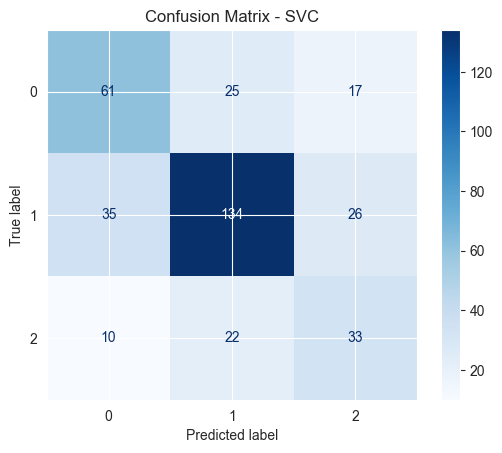

                 Model  Accuracy  Macro F1  Class 0 F1  Class 1 F1  Class 2 F1
0                  SVC  0.628099  0.588194    0.583732    0.712766    0.468085
1  Logistic Regression  0.611570  0.576809    0.560386    0.699454    0.470588
2                  KNN  0.600551  0.566098    0.555556    0.681199    0.461538


In [23]:

models = {
    "Logistic Regression": logreg_gs.best_estimator_,
    "KNN": knn_gs.best_estimator_,
    "SVC": svc_gs.best_estimator_,
}

cv_scores = {
    "Logistic Regression": logreg_gs.best_score_,
    "KNN": knn_gs.best_score_,
    "SVC": svc_gs.best_score_,
}

best_model_name = max(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]


X_test_sfs = test[selected_features].copy()
y_test = test['target'].copy()

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_sfs)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=sorted(y_test.unique())
    )

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Macro F1': f1.mean(),
        'Class 0 F1': f1[0],
        'Class 1 F1': f1[1],
        'Class 2 F1': f1[2] if len(f1) > 2 else np.nan
    })

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

results_df = pd.DataFrame(results)
print(results_df.sort_values("Macro F1", ascending=False).reset_index(drop=True))

# Interpretation

SVC has the highest overall performance with a top macro-F1 of 0.59 and accuracy of 63%.
SVC shows strong classification performance for Class 1 since it is the majority class, to make the
performance also comparable with Class 0 and 2 we can use minority oversampling / majority undersampling

In [27]:
import pickle

model_path = root / 'models'
model_path.mkdir(parents=True, exist_ok=True)

models_to_save = {
    'logreg_model.pkl': logreg_gs.best_estimator_,
    'knn_model.pkl': knn_gs.best_estimator_,
    'svc_model.pkl': svc_gs.best_estimator_,
}

for filename, model in models_to_save.items():
    with open(model_path / filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filename}")

Saved: logreg_model.pkl
Saved: knn_model.pkl
Saved: svc_model.pkl
